Example notebook showing how to use the nested sampler with a lower number of live points and MCMC steps

In [1]:
import os
import sys
import argparse
import torch
import logging
from getdist import plots, MCSamples
import getdist
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import NestedSampler
from nnest.likelihoods import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood + prior
#like = Himmelblau(2)
#transform = lambda x: 5*x
like = Rosenbrock(3)
transform = lambda x: 5*x
#like = Gaussian(2, 0.9)
#transform = lambda x: 3*x
#like = Eggbox(2)
#transform = lambda x: 5*np.pi*x
#like = GaussianShell(2)
#transform = lambda x: 5*x
#like = GaussianMix(2)
#transform = lambda x: 5*x

In [6]:
sampler = NestedSampler(like.x_dim, like, transform=transform, num_live_points=200, hidden_dim=16, 
                        num_blocks=3, flow='spline')

Creating directory for new run logs/test/run34
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=2, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_fe

In [7]:
sampler.run(strategy=['rejection_prior', 'rejection_flow', 'mcmc'], mcmc_steps=2*like.x_dim)

[nnest.sampler] [INFO] MCMC steps [6]
[nnest.sampler] [INFO] Initial scale [1.1547]
[nnest.sampler] [INFO] Volume switch [-1.0000]
[nnest.sampler] [INFO] Step [0] loglstar [-1.1638e+05] max logl [-3.0072e+01] logz [-1.1639e+05] vol [1.00000e+00] ncalls [201] mean calls [0.0000]
[nnest.sampler] [INFO] Step [40] loglstar [-4.5254e+04] max logl [-3.0072e+01] logz [-4.5259e+04] vol [8.18731e-01] ncalls [251] mean calls [1.4500]
[nnest.sampler] [INFO] Step [80] loglstar [-2.9652e+04] max logl [-2.1878e+01] logz [-2.9657e+04] vol [6.70320e-01] ncalls [313] mean calls [1.7000]
[nnest.sampler] [INFO] Step [120] loglstar [-2.1189e+04] max logl [-2.1878e+01] logz [-2.1194e+04] vol [5.48812e-01] ncalls [378] mean calls [1.7500]
[nnest.sampler] [INFO] Step [160] loglstar [-1.5911e+04] max logl [-2.1878e+01] logz [-1.5917e+04] vol [4.49329e-01] ncalls [449] mean calls [2.0000]
[nnest.sampler] [INFO] Step [200] loglstar [-1.2153e+04] max logl [-9.5590e+00] logz [-1.2159e+04] vol [3.67879e-01] ncalls

[nnest.sampler] [INFO] Step [1360] loglstar [-1.3310e+01] maxlogl [-3.3210e-01] logz [-2.3089e+01] vol [1.11378e-03] ncalls [4885] scale [0.2370]
[nnest.trainer] [INFO] Number of training samples [200]
[nnest.trainer] [INFO] Training jitter [0.0022]
[nnest.trainer] [INFO] Epoch [1] train loss [-0.0426] validation loss [-0.1964]
[nnest.trainer] [INFO] Epoch [100] train loss [-0.0528] validation loss [-0.2131]
[nnest.trainer] [INFO] Epoch [124] ran out of patience
[nnest.trainer] [INFO] Best epoch [74] validation loss [-0.2178]
[nnest.sampler] [INFO] Acceptance [0.4000] min ESS [2.7286] max ESS [4.7480] average jump [0.0452]
[nnest.sampler] [INFO] Step [1400] loglstar [-1.1390e+01] maxlogl [-3.3210e-01] logz [-2.0512e+01] vol [9.11882e-04] ncalls [5055] scale [0.2293]
[nnest.sampler] [INFO] Acceptance [0.4167] min ESS [3.7357] max ESS [4.4300] average jump [0.0351]
[nnest.sampler] [INFO] Step [1440] loglstar [-9.6100e+00] maxlogl [-3.3210e-01] logz [-1.8803e+01] vol [7.46586e-04] ncalls 

In [8]:
print(sampler.logz)

-10.407591254774323


In [9]:
mc = MCSamples(samples=sampler.samples, weights=sampler.weights, loglikes=-sampler.loglikes)

Removed no burn in


In [10]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.likeStats)

63.71994473524645
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      8.1321346E-01  4.7622702E-01  5.5657887E-01  1.3274222E+00  two   -2.0029893E-01  1.6158317E+00  two   -9.1819294E-01  1.6723600E+00  two     p_{1}
param2      8.8357029E-01  5.8898235E-01  1.7077436E-01  1.3817629E+00  two   -1.2676469E-01  2.0475505E+00  two   -3.2147481E-01  2.3233151E+00  two     p_{2}
param3      1.1271013E+00  1.2202612E+00 -1.3513859E-01  1.4052429E+00  two   -2.2600254E-01  4.4085277E+00  two   -2.5014523E-01  4.6169199E+00  two     p_{3}

Best fit sample -log(Like) = 0.011484
mean(-Ln(like)) = 1.599356
-Ln(mean like)  = 1.084408

parameter   bestfit        lower1         upper1         lower2         upper2
param1      1.0296705E+00  1.2281651E-01  1.4798316E+00 -9.2495412E-01  1.5307459E+00   p_{1}
param2      1.0587590E+00  6.6154532E-03  

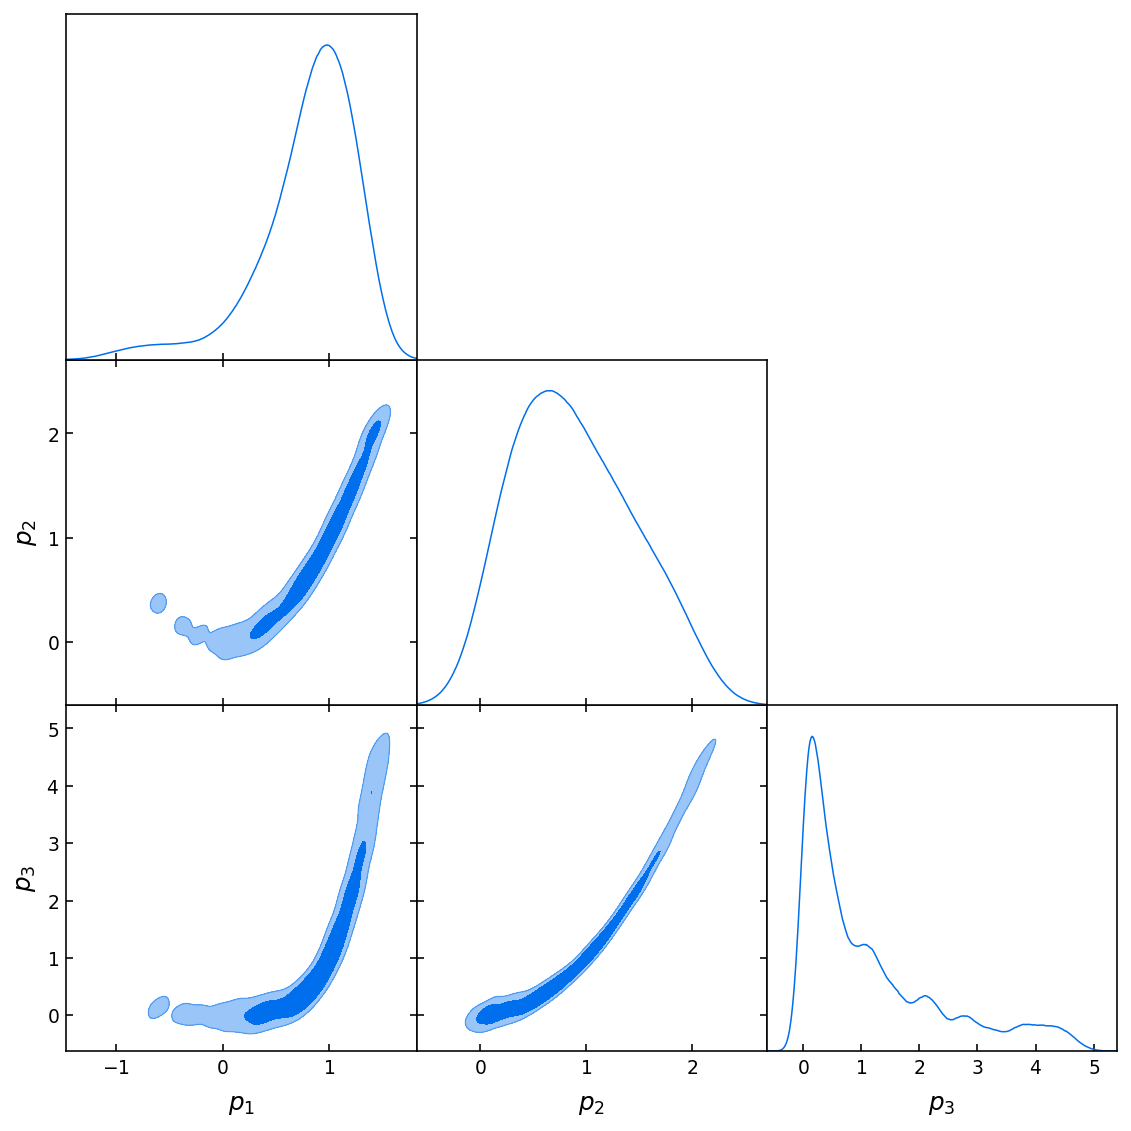

In [11]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)